# Cluster data using Expectation-Maximization Algorithm

### Import neccessary packages

In [1]:
import graphlab as gl
import numpy as np
import matplotlib.pyplot as plt 
import copy
from scipy.stats import multivariate_normal

%matplotlib inline

[WARNING] graphlab.product_key: Unable to write current GraphLab Create license to /home/abaghel/.graphlab/config. Ensure that this user account                         has write permission to /home/abaghel/.graphlab/config to save the license for offline use.
[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1480656168.log


This non-commercial license of GraphLab Create for academic use is assigned to baghelpatna@gmail.com and will expire on August 05, 2017.


[WARNING] graphlab.deploy._session: Unable to create session in specified location: '/home/abaghel/.graphlab/artifacts'. Using: '/var/tmp/graphlab-abaghel/7659/tmp_session_7d679475-3c01-48a1-b69c-10465660b15e'


# Implementing the EM algorithm for Gaussian mixture models

In this section, you will implement the EM algorithm. We will take the following steps:

*    Create representative synthetic data.
*    Provide a log likelihood function for this model.
*    Implement the EM algorithm.
*    Visualize the progress of the parameters during the course of running EM.
*    Visualize the convergence of the model.



## Dataset

To help us develop and test our implementation, we will generate some observations from a mixture of Gaussians and then run our EM algorithm to discover the mixture components. We'll begin with a function to generate the data, and a quick plot to visualize its output for a 2-dimensional mixture of three Gaussians.

Now we will create a function to generate data from a mixture of Gaussians model.


### Assumptions for our dataset:

* All data features can be represented as Gaussian or mmixture of Gaussian curves
* Examples: Claimed amount for a particular DRG may look like a simple skewed Gaussian curve
* More complex continuous distributions can be represented as overlapping Gaussian curves
* These assumptioms are only for Mathematical robustness


### Requirements of our model:

* Must allow for n-features
* Must facilitate for scalable frameworks like Map Reduce

In [2]:
def generate_MoG_data(num_data, means, covariances, weights):
    """ Creates a list of data points """
    num_clusters = len(weights)
    data = []
    for i in range(num_data):
        #  Use np.random.choice and weights to pick a cluster id greater than or equal to 0 and less than num_clusters.
        k = np.random.choice(len(weights), 1, p=weights)[0]

        # Use np.random.multivariate_normal to create data from this cluster
        x = np.random.multivariate_normal(means[k], covariances[k])

        data.append(x)
    return data

In [45]:
# Model parameters
init_means = [
    [50, 30], # mean of cluster 1
    [0, 50], # mean of cluster 2
    [40, 50]  # mean of cluster 3
]
init_covariances = [
    [[150., 0.], [0, 55.]], # covariance of cluster 1
    [[200., 35.], [0, 200.]], # covariance of cluster 2
    [[150., 0.], [0, 150.]]  # covariance of cluster 3
]
init_weights = [1/4., 1/2., 1/4.]  # weights of each cluster

# Generate data
np.random.seed(4)
data = generate_MoG_data(1000, init_means, init_covariances, init_weights)

In [46]:
assert len(data) == 1000
assert len(data[0]) == 2
print 'Checkpoint passed!'

Checkpoint passed!


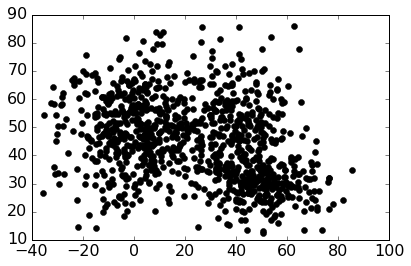

In [47]:
plt.figure()
d = np.vstack(data)
plt.plot(d[:,0], d[:,1],'ko')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

## Convergence: Log likelihood

We provide a function to calculate log likelihood for mixture of Gaussians. The log likelihood quantifies the probability of observing a given set of data under a particular setting of the parameters in our model. We will use this to assess convergence of our EM algorithm; specifically, we will keep looping through EM update steps until the log likehood ceases to increase at a certain rate.


In [48]:
def log_sum_exp(Z):
    """ Compute log(\sum_i exp(Z_i)) for some array Z."""
    return np.max(Z) + np.log(np.sum(np.exp(Z - np.max(Z))))

def loglikelihood(data, weights, means, covs):
    """ Compute the loglikelihood of the data for a Gaussian mixture model with the given parameters. """
    num_clusters = len(means)
    num_dim = len(data[0])
    
    ll = 0
    for d in data:
        
        Z = np.zeros(num_clusters)
        for k in range(num_clusters):
            
            # Compute (x-mu)^T * Sigma^{-1} * (x-mu)
            delta = np.array(d) - means[k]
            exponent_term = np.dot(delta.T, np.dot(np.linalg.inv(covs[k]), delta))
            
            # Compute loglikelihood contribution for this data point and this cluster
            Z[k] += np.log(weights[k])
            Z[k] -= 1/2. * (num_dim * np.log(2*np.pi) + np.log(np.linalg.det(covs[k])) + exponent_term)
            
        # Increment loglikelihood contribution of this data point across all clusters
        ll += log_sum_exp(Z)
        
    return ll



## Implementation

In [49]:
def EM(data, init_means, init_covariances, init_weights, maxiter=1000, thresh=1e-4, print_iter=True):
    
    # Make copies of initial parameters, which we will update during each iteration
    means = init_means[:]
    covariances = init_covariances[:]
    weights = init_weights[:]
#     print means
    
    # Infer dimensions of dataset and the number of clusters
    num_data = len(data)
    num_dim = len(data[0])
    num_clusters = len(means)
    
    # Initialize some useful variables
    resp = np.zeros((num_data, num_clusters))
    ll = loglikelihood(data, weights, means, covariances)
    ll_trace = [ll]
    
    for i in range(maxiter):
        if(print_iter):
            if i % 5 == 0:
                print("Iteration %s" % i)
        
        # E-step: compute responsibilities
        # Update resp matrix so that resp[j, k] is the responsibility of cluster k for data point j.
        # To compute likelihood of seeing data point j given cluster k, use multivariate_normal.pdf.
        for j in range(num_data):
            for k in range(num_clusters):
                # YOUR CODE HERE
                resp[j, k] = multivariate_normal.pdf(data[j], means[k], covariances[k])*weights[k]
        row_sums = resp.sum(axis=1)[:, np.newaxis]
        resp = resp / row_sums # normalize over all possible cluster assignments

        # M-step
        # Compute the total responsibility assigned to each cluster, which will be useful when 
        # implementing M-steps below. This is also called N^{soft}
        counts = np.sum(resp, axis=0)
        
        for k in range(num_clusters):
            Nsoft = counts[k]
            # Update the weight for cluster k using the M-step update rule for the cluster weight, \hat{\pi}_k.
            # YOUR CODE HERE
            weights[k] = Nsoft*1./num_data
            
            # Update means for cluster k using the M-step update rule for the mean variables.
            # This will assign the variable means[k] to be our estimate for \hat{\mu}_k.
            weighted_sum = 0
            for j in range(num_data):
                # YOUR CODE HERE
                weighted_sum += resp[j,k]*data[j]
            # YOUR CODE HERE
            means[k] = weighted_sum*1./Nsoft
            
            # Update covariances for cluster k using the M-step update rule for covariance variables.
            # This will assign the variable covariances[k] to be the estimate for \hat{\Sigma}_k.
            weighted_sum = np.zeros((num_dim, num_dim))
            for j in range(num_data):
                weighted_sum += (np.outer(data[j]-means[k],data[j]-means[k])*resp[j,k])
            covariances[k] = weighted_sum*1./Nsoft
          
        
        # Compute the loglikelihood at this iteration
        ll_latest = loglikelihood(data, weights, means, covariances)
        ll_trace.append(ll_latest)
        
        # Check for convergence in log-likelihood and store
        if (ll_latest - ll) < thresh and ll_latest > -np.inf:
            break
        ll = ll_latest
    
    if(print_iter):
        if i % 5 != 0:
            print("Iteration %s" % i)
    
    out = {'weights': weights, 'means': means, 'covs': covariances, 'loglik': ll_trace, 'resp': resp}

    return out

In [50]:
np.random.seed(4)

# Initialization of parameters
chosen = np.random.choice(len(data), 3, replace=False)
initial_means = [data[x] for x in chosen]
initial_covs = [np.cov(data, rowvar=0)] * 3
initial_weights = [1/3.] * 3

# Run EM 
results = EM(data, initial_means, initial_covs, initial_weights)

Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 25
Iteration 30
Iteration 35
Iteration 40
Iteration 45
Iteration 50
Iteration 55
Iteration 60
Iteration 65
Iteration 70
Iteration 75
Iteration 80
Iteration 85
Iteration 90
Iteration 95
Iteration 100
Iteration 105
Iteration 110
Iteration 115
Iteration 119


Our algorithm returns a dictionary with five elements:

*    'loglik': a record of the log likelihood at each iteration
*    'resp': the final responsibility matrix
*    'means': a list of K means
*    'covs': a list of K covariance matrices
*    'weights': the weights corresponding to each model component



### =================================================================

## Visualization


### Plot progress of parameters

One useful feature of testing our implementation on low-dimensional simulated data is that we can easily visualize the results.

We will use the following plot_contours function to visualize the Gaussian components over the data at different points in the algorithm's execution:

*    At initialization (using initial_mu, initial_cov, and initial_weights)
*    After running the algorithm to completion
*    After every nth iteration (using parameters estimates returned when setting maxiter=n*iter_step)



In [62]:
import matplotlib.mlab as mlab
def plot_contours(data, means, covs, title):
    plt.figure()
    plt.plot([x[0] for x in data], [y[1] for y in data],'k.') # data

    delta = 5.0
    k = len(means)
    x = np.arange(-50.0, 100.0, delta)
    y = np.arange(0.0, 100.0, delta)
    X, Y = np.meshgrid(x, y)
    col = ['green', 'red', 'indigo']
    for i in range(k):
        mean = means[i]
        cov = covs[i]
        sigmax = np.sqrt(cov[0][0])
        sigmay = np.sqrt(cov[1][1])
        sigmaxy = cov[0][1]/(sigmax*sigmay)
        Z = mlab.bivariate_normal(X, Y, sigmax, sigmay, mean[0], mean[1], sigmaxy)
        plt.contour(X, Y, Z, colors = col[i], linewidths=3)
        
        plt.title(title)
    plt.rcParams.update({'font.size':16})
    plt.tight_layout()

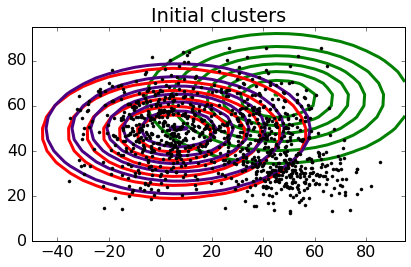

In [63]:
# Parameters after initialization
plot_contours(data, initial_means, initial_covs, 'Initial clusters')

## Vizualize the cluster convergence

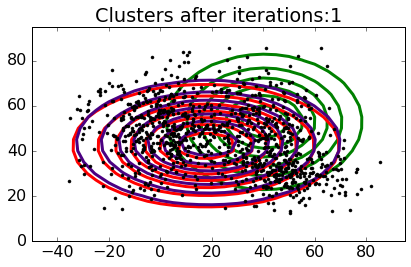

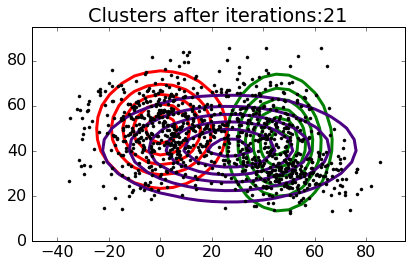

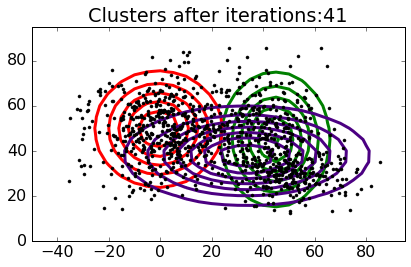

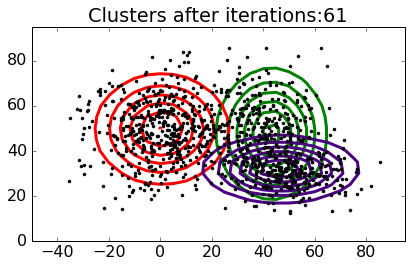

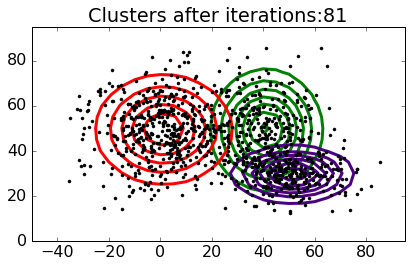

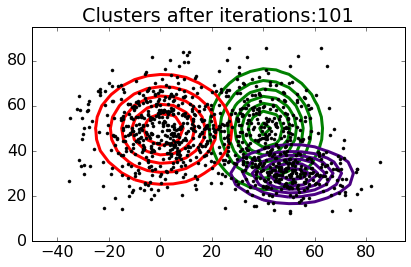

In [64]:
for n in range(1,120,20):
    results = EM(data, initial_means, initial_covs, initial_weights, print_iter = False, maxiter=n)
    plot_contours(data, results['means'], results['covs'], 'Clusters after iterations:'+ str(n))

## Final Clusters

Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 25
Iteration 30
Iteration 35
Iteration 40
Iteration 45
Iteration 50
Iteration 55
Iteration 60
Iteration 65
Iteration 70
Iteration 75
Iteration 80
Iteration 85
Iteration 90
Iteration 95
Iteration 100
Iteration 105
Iteration 110
Iteration 115
Iteration 119


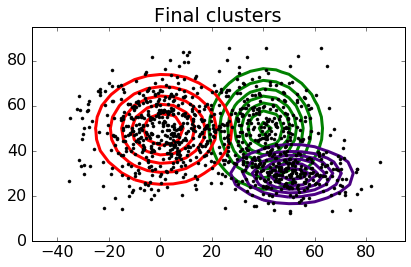

In [66]:
# Parameters after running EM to convergence
results = EM(data, initial_means, initial_covs, initial_weights)
plot_contours(data, results['means'], results['covs'], 'Final clusters')

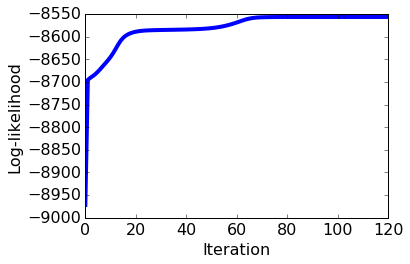

In [67]:
## Check for saturation of log likelihood:
loglikelihoods = results['loglik']
plt.plot(range(len(loglikelihoods)), loglikelihoods, linewidth=4)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.rcParams.update({'font.size':16})
plt.tight_layout()